## Import dependencies

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os

Python version: 3.10.10
Tensorflow version: 2.10.0
Keras version: 2.10.0


## Download the dataset

In [2]:
cache_dir = './tmp'
dataset_file_name = 'shakespeare.txt'
dataset_file_origin = 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'

dataset_file_path = tf.keras.utils.get_file(
    fname=dataset_file_name,
    origin=dataset_file_origin,
    cache_dir=pathlib.Path(cache_dir).absolute()
)

print(dataset_file_path)

1115394/1115394 [==============================] - 1s 1us/step
/tmp\.keras\datasets\shakespeare.txt


## Analyze the dataset

In [3]:
# Reading the database file.
text = open(dataset_file_path, mode='r').read()

print('Length of text: {} characters'.format(len(text)))

Length of text: 1115394 characters


In [4]:
# Take a look at the first 250 characters in text.
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [5]:
# The unique characters in the file
vocab = sorted(set(text))

print('{} unique characters'.format(len(vocab)))
print('vocab:', vocab)

65 unique characters
vocab: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Process the dataset

### Vectorize the text

Before feeding the text to our RNN we need to convert the text from a sequence of characters to a sequence of numbers. To do so we will detect all unique characters in the text, form a vocabulary out of it and replace each character with its index in the vocabulary.

In [6]:
# Map characters to their indices in vocabulary.
char2index = {char: index for index, char in enumerate(vocab)}

print('{')
for char, _ in zip(char2index, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2index[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '$' :   3,
  '&' :   4,
  "'" :   5,
  ',' :   6,
  '-' :   7,
  '.' :   8,
  '3' :   9,
  ':' :  10,
  ';' :  11,
  '?' :  12,
  'A' :  13,
  'B' :  14,
  'C' :  15,
  'D' :  16,
  'E' :  17,
  'F' :  18,
  'G' :  19,
  ...
}


In [7]:
# Map character indices to characters from vacabulary.
index2char = np.array(vocab)
print(index2char)

['\n' ' ' '!' '$' '&' "'" ',' '-' '.' '3' ':' ';' '?' 'A' 'B' 'C' 'D' 'E'
 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W'
 'X' 'Y' 'Z' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o'
 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [8]:
# Convert chars in text to indices.
text_as_int = np.array([char2index[char] for char in text])

print('text_as_int length: {}'.format(len(text_as_int)))
print('{} --> {}'.format(repr(text[:15]), repr(text_as_int[:15])))

text_as_int length: 1115394
'First Citizen:\n' --> array([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0])


## Create training sequences

In [9]:
# The maximum length sentence we want for a single input in characters.
sequence_length = 100
examples_per_epoch = len(text) // (sequence_length + 1)

print('examples_per_epoch:', examples_per_epoch)

examples_per_epoch: 11043


In [10]:
# Create training dataset.
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for char in char_dataset.take(5):
    print(index2char[char.numpy()])

F
i
r
s
t


In [11]:
# Generate batched sequences out of the char_dataset.
sequences = char_dataset.batch(sequence_length + 1, drop_remainder=True)

# Sequences size is the same as examples_per_epoch.
print('Sequences count: {}'.format(len(list(sequences.as_numpy_iterator()))));
print()

# Sequences examples.
for item in sequences.take(5):
    print(repr(''.join(index2char[item.numpy()])))

Sequences count: 11043

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [12]:
# sequences shape:
# - 11043 sequences
# - Each sequence of length 101
#
#
#    101     101          101
# [(.....) (.....) ...  (.....)]
#
# <---------- 11043 ----------->

For each sequence, duplicate and shift it to form the input and target text. For example, say `sequence_length` is `4` and our text is `Hello`. The input sequence would be `Hell`, and the target sequence `ello`.

In [13]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

In [14]:
dataset = sequences.map(split_input_target)

# Dataset size is the same as examples_per_epoch.
# But each element of a sequence is now has length of `sequence_length`
# and not `sequence_length + 1`.
print('dataset size: {}'.format(len(list(dataset.as_numpy_iterator()))))

dataset size: 11043


In [15]:
for input_example, target_example in dataset.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    print('Input:', repr(''.join(index2char[input_example.numpy()])))
    print('Target:', repr(''.join(index2char[target_example.numpy()])))

Input sequence size: 100
Target sequence size: 100

Input: 'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: 'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [16]:
# dataset shape:
# - 11043 sequences
# - Each sequence is a tuple of 2 sub-sequences of length 100 (input_text and target_text)
#
#
#    100       100           100
# /(.....)\ /(.....)\ ... /(.....)\  <-- input_text
# \(.....)/ \(.....)/     \(.....)/  <-- target_text
#
# <----------- 11043 ------------->

Each index of these vectors are processed as one time step. For the input at time step 0, the model receives the index for "F" and trys to predict the index for "i" as the next character. At the next timestep, it does the same thing but the RNN considers the previous step context in addition to the current input character.

In [17]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print('Step {:2d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(index2char[target_idx])))

Step  0
  input: 18 ('F')
  expected output: 47 ('i')
Step  1
  input: 47 ('i')
  expected output: 56 ('r')
Step  2
  input: 56 ('r')
  expected output: 57 ('s')
Step  3
  input: 57 ('s')
  expected output: 58 ('t')
Step  4
  input: 58 ('t')
  expected output: 1 (' ')


## Split training sequences into batches

We used `tf.data` to split the text into manageable sequences. But before feeding this data into the model, we need to shuffle the data and pack it into batches.

In [18]:
# Batch size.
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int32, name=None), TensorSpec(shape=(64, 100), dtype=tf.int32, name=None))>

In [19]:
print('Batched dataset size: {}'.format(len(list(dataset.as_numpy_iterator()))))

Batched dataset size: 172


In [20]:
for input_text, target_text in dataset.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[32 17 31 ...  1 63 53]
 [50 47 43 ... 13 30  1]
 [59 12  0 ... 39 60 43]
 ...
 [20 43 52 ... 17 26 15]
 [ 1 42 43 ... 52  1 57]
 [53 59  1 ... 57  1 53]], shape=(64, 100), dtype=int32)

1st batch: target_text: tf.Tensor(
[[17 31 10 ... 63 53 59]
 [47 43 58 ... 30  1 24]
 [12  0  0 ... 60 43  6]
 ...
 [43 52 41 ... 26 15 17]
 [42 43 44 ...  1 57 53]
 [59  1 50 ...  1 53 44]], shape=(64, 100), dtype=int32)


In [21]:
# dataset shape:
# - 172 batches
# - 64 sequences per batch
# - Each sequence is a tuple of 2 sub-sequences of length 100 (input_text and target_text)
#
#
#     100       100           100             100       100           100
# |/(.....)\ /(.....)\ ... /(.....)\| ... |/(.....)\ /(.....)\ ... /(.....)\|  <-- input_text
# |\(.....)/ \(.....)/     \(.....)/| ... |\(.....)/ \(.....)/     \(.....)/|  <-- target_text
#
# <------------- 64 ---------------->     <------------- 64 ---------------->
#
# <--------------------------------- 172 ----------------------------------->

## Build the model

Use [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) to define the model. For this simple example three layers are used to define our model:

- [tf.keras.layers.Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
- [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): A type of RNN with size units=rnn_units (You can also use a GRU layer here.)
- [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): The output layer, with vocab_size outputs.

In [23]:
# Length of the vocabulary in chars.
vocab_size = len(vocab)

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.
rnn_units = 1024

In [42]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
      units=rnn_units,
      return_sequences=True,
      stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.LSTM(
      units=rnn_units,
      return_sequences=True,
      stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
  
    return model

In [43]:
model = build_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

In [44]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (64, None, 256)           16640     
                                                                 
 lstm_1 (LSTM)               (64, None, 1024)          5246976   
                                                                 
 lstm_2 (LSTM)               (64, None, 1024)          8392704   
                                                                 
 dense_1 (Dense)             (64, None, 65)            66625     
                                                                 
Total params: 13,722,945
Trainable params: 13,722,945
Non-trainable params: 0
_________________________________________________________________


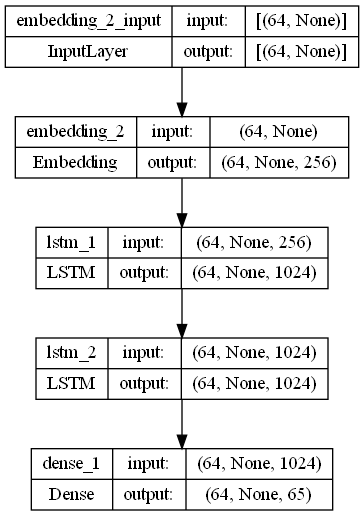

In [45]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

![Model architecture](https://www.tensorflow.org/tutorials/text/images/text_generation_training.png)

Image source: [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation) notebook.

## Try the model

In [46]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")


(64, 100, 65) # (batch_size, sequence_length, vocab_size)


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

In [47]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[-1.92888110e-04  3.34222335e-04  3.39201826e-04  5.92028955e-04
 -3.57899640e-04 -1.11551140e-03  4.15367656e-04  6.01280190e-04
 -7.12834531e-04 -1.21970246e-04  3.37307691e-04  8.32853140e-04
 -9.62798658e-05 -3.79182049e-04 -6.60646241e-04 -3.45128792e-04
 -1.24377210e-03  7.16120994e-05  7.01010460e-04  5.50427823e-04
  6.25760935e-04  6.97179174e-04  8.66490300e-04 -9.25681088e-05
 -1.50395208e-04 -5.33189508e-04 -3.28102149e-04 -6.28422014e-04
  4.10321867e-04 -4.62058350e-04 -2.06527475e-05  4.38144780e-04
 -4.54264431e-04 -1.89109240e-04  2.39602930e-04  3.71321774e-04
 -5.78447143e-05  1.44648104e-04  8.07754404e-05  9.54996853e-04
  6.70051668e-05  7.86810240e-04 -1.87849306e-04 -4.27703053e-04
 -2.79776810e-04  1.69623643e-04 -1.45293889e-05  2.34475301e-04
 -1.16693409e-04 -5.77946368e-04  8.49929522e-04 -3.51251045e-04
 -2.22199742e-04 -3.27542919e-04 -7.84705859e-04 -3.39275546e-04
  5.65474678e-04 -9.26

In [48]:
# Quick overview of how tf.random.categorical() works.

# logits is 2-D Tensor with shape [batch_size, num_classes].
# Each slice [i, :] represents the unnormalized log-probabilities for all classes.
# In the example below we say that the probability for class "0" is low but the
# probability for class "2" is much higher.
tmp_logits = [
  [-0.95, 0, 0.95],
];

# Let's generate 5 samples. Each sample is a class index. Class probabilities 
# are being taken into account (we expect to see more samples of class "2").
tmp_samples = tf.random.categorical(
    logits=tmp_logits,
    num_samples=5
)

print(tmp_samples)

tf.Tensor([[2 2 2 1 0]], shape=(1, 5), dtype=int64)


In [49]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

sampled_indices.shape

TensorShape([100, 1])

In [50]:
sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

sampled_indices.shape

(100,)

In [51]:
sampled_indices

array([ 9, 53, 17, 37, 28,  9, 51, 48, 35, 14,  6, 44, 28, 59,  7, 64, 57,
       51, 39, 46, 24, 34, 36, 49, 22, 51, 30, 27, 35,  4, 48,  8, 24, 32,
       32, 35, 48, 19,  3, 20, 24, 14, 55, 40, 28, 10, 48,  9,  9, 10, 37,
       57, 13, 28, 49, 30,  5, 13, 20, 63, 57,  0, 24,  3, 11, 43, 61,  7,
       56, 47, 13, 58, 26, 32, 45, 32, 51, 37, 52, 28, 52,  2, 38, 17, 11,
       20, 14, 23, 15, 30, 52, 34, 60,  6,  1,  8, 17, 23, 29, 50],
      dtype=int64)

In [52]:
print('Input:\n', repr(''.join(index2char[input_example_batch[0]])))
print()
print('Next char prediction:\n', repr(''.join(index2char[sampled_indices])))

Input:
 "l stir.\n\nPAULINA:\nMusic, awake her; strike!\n'Tis time; descend; be stone no more; approach;\nStrike a"

Next char prediction:
 "3oEYP3mjWB,fPu-zsmahLVXkJmROW&j.LTTWjG$HLBqbP:j33:YsAPkR'AHys\nL$;ew-riAtNTgTmYnPn!ZE;HBKCRnVv, .EKQl"


In [53]:
for i, (input_idx, sample_idx) in enumerate(zip(input_example_batch[0][:5], sampled_indices[:5])):
    print('Prediction {:2d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
    print('  next predicted: {} ({:s})'.format(target_idx, repr(index2char[sample_idx])))

Prediction  0
  input: 50 ('l')
  next predicted: 1 ('3')
Prediction  1
  input: 1 (' ')
  next predicted: 1 ('o')
Prediction  2
  input: 57 ('s')
  next predicted: 1 ('E')
Prediction  3
  input: 58 ('t')
  next predicted: 1 ('Y')
Prediction  4
  input: 47 ('i')
  next predicted: 1 ('P')


## Train the model

At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

### Attach an optimizer, and a loss function

In [54]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 65)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.174623


In [55]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

### Configure checkpoints

In [56]:
# Directory where the checkpoints will be saved.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

### Execute the training

In [60]:
EPOCHS=50

In [61]:
# history = model.fit(
#   x=dataset,
#   epochs=EPOCHS,
#   callbacks=[
#     checkpoint_callback
#   ]
# )

Epoch 1/50
172/172 [==============================] - 824s 5s/step - loss: 2.6306
Epoch 2/50
172/172 [==============================] - 802s 5s/step - loss: 1.8736
Epoch 3/50
172/172 [==============================] - 802s 5s/step - loss: 1.5862
Epoch 4/50
172/172 [==============================] - 801s 5s/step - loss: 1.4514
Epoch 5/50
172/172 [==============================] - 801s 5s/step - loss: 1.3704
Epoch 6/50
172/172 [==============================] - 800s 5s/step - loss: 1.3135
Epoch 7/50
172/172 [==============================] - 802s 5s/step - loss: 1.2634
Epoch 8/50
172/172 [==============================] - 800s 5s/step - loss: 1.2171
Epoch 9/50
172/172 [==============================] - 800s 5s/step - loss: 1.1702
Epoch 10/50
172/172 [==============================] - 802s 5s/step - loss: 1.1224
Epoch 11/50
172/172 [==============================] - 799s 5s/step - loss: 1.0722
Epoch 12/50
172/172 [==============================] - 799s 5s/step - loss: 1.0193
Epoch 13/50
1

In [62]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

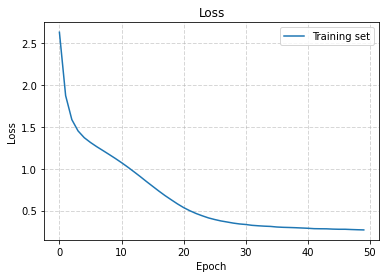

In [63]:
render_training_history(history)

## Generating new text

### Restoring the saved model

(Since, we've already saved the model as a h5 file we'll just be reloading it for predicitions)

In [2]:
# load the saved model
from tensorflow.keras.models import load_model
model = load_model('text_generation_shakespeare_rnn.h5')

In [3]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (1, None, 256)            16640     
                                                                 
 lstm_3 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 lstm_4 (LSTM)               (1, None, 1024)           8392704   
                                                                 
 dense_2 (Dense)             (1, None, 65)             66625     
                                                                 
Total params: 13,722,945
Trainable params: 13,722,945
Non-trainable params: 0
_________________________________________________________________


### The prediction loop

The following code block generates the text:

- It Starts by choosing a start string, initializing the RNN state and setting the number of characters to generate.

- Get the prediction distribution of the next character using the start string and the RNN state.

- Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted character as our next input to the model.

- The RNN state returned by the model is fed back into the model so that it now has more context, instead than only one character. After predicting the next character, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted characters.


In [4]:
# num_generate
# - number of characters to generate.
#
# temperature
# - Low temperatures results in more predictable text.
# - Higher temperatures results in more surprising text.
# - Experiment to find the best setting.

def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing).
    input_indices = [char2index[s] for s in start_string]
    input_indices = tf.expand_dims(input_indices, 0)

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
        predictions,
        num_samples=1
        )[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)
        
        text_generated.append(index2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [68]:
# Generate the text with default temperature (1.0).
print(generate_text(model, start_string=u"ROMEO: "))

ROMEO: Mough, I am past my gamish form,
And in A gamwer, but not from thy death:
Because that I am little, like an Hereford's life;
Resign'd his face to taste pardon me; indeed, paid dow
Upon the first seeming out thou drink before.

GRUMIO:
More of Warwick, kill, kill, kill him!

Lors:
Go yet name ET:
Why, br I started, and with curses and aid
With weal apparel endonce to speak.
Sound trumpets! let our bloody colours wave!
And either victory, or en they that fly there?

WARWICK:
Richard yet lives, unfold that painting courses'
With instruments and practh in this business, and
lay aside the next wart of hell.

Second Servant:
I have a head, my life in dwit
imong him.

HORTENSIO:
Faith, as you say, there's small choice in rotten winter,
That I should say 'I, past here looks as thoughts
To batle it. He was no more dumour last,
Your safety lies the suble and degreed,
Not one unwar' feat'd?

SEBASTIAN:
He receives comfort like cold porret,
And perish constant fools. Who is't can blame him.

In [69]:
# Generate the text with higher temperature to get more unexpected results.
print(generate_text(model, start_string=u"ROMEO: ", temperature=1.5))

ROMEO: George Stanley, be not so;
For she's a woman images: when he wanded,
That I should I: fiends to heluthfulmy creature in her,
I thought my part seems high.

ESCALUS:
Thanks.

ESCALUS:
Go to; I spy a lackeore
II would thyself a threfored gap,
Proclaims us on earth.
Riast thou the king.

DUCHESS OF YORK:
Stouo her; then' Kated:'
In all things sparkling in oriviow in rest!
For raging wind-advice but me gINRTET:
Etrance wearing
To help him to hich sovereignty.

QUEEN ELIZABETH:
Cousinople! fair office.

DERBY:
Rebe you, no. Citizensties; where geaks will feel guess,
I would se! 'I must wear?

FLORIZEL:
It cannot faithful Edward comes;
Or walk befough me rtinus your glass gINCENTIO:
The father's grave pisation queens!
For Easwall her come, fat, icle of the sport of st kert
Yourws!
But what worces the rascal cook?
Heaven seen, you lie to-morrow! O injudy painful new, receives mine own our drift,
Unless you walk lecaio; for 'tis all one,
Your honour he ne'er spoke, you wept thou not--
H

In [74]:
# Generate the text with higher temperature to get more unexpected results.
print(generate_text(model, start_string=u"whip", temperature=0.4))

whipping, after I have stay'd ten days' wonder at the least.

CLARENCE:
This day here lies the mustard, gentle Warwick,
Edwart Please you, farther.

PROSPERO:
Thou hast. Where was she born? speak; tell me.

ARIEL:
Sir, in this rage, with some strange lunaticulark!
This is the day that, in King Edward's time
I will unfold some causes of your daughter.

LADY CAPULET:
We follow thee.
Juliet, the county stays.

Nurse:
Sir, a word with our weather?

FLORIZEL:
Most noble countrymen, proud queen, to make my taught
The queen of my imprisonment and pawn,
And bow unproved their country's broken wing,
Nor when thy warlike father, like a child,
To meet them in the present and most beatle.

Second Murderer:
What, shall we suffer this? let's part.

POLIXENES:
I pray thee, good Camillo, be no more importunate:
'tis a sickness denying that I have to love thee
Doth much excuse the appear with my wind we sadly in this troublous world,
To meet with joy in sweet Jerusalem.

KING EDWARD IV:
Is proclamation

## Save the model

In [70]:
# model_name = 'text_gen_final.h5'
# model.save(model_name, save_format='h5')